In [ ]:
# Step 1: Data Preparation (Same as Before)
import zipfile, os
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
}
# Upload Sinograms
print("Upload zipped sinogram folder: ")
sino_zip = files.upload()
sino_zip_name = list(sino_zip.keys())[0]

# Upload CTs
print("Upload zipped CT Image folder: ")
ct_zip = files.upload()
ct_zip_name = list(ct_zip.keys())[0]


Upload zipped sinogram folder: 


Saving sino_finallll.zip to sino_finallll (2).zip
Upload zipped CT Image folder: 


Saving CT_64x64_RESIZED.zip to CT_64x64_RESIZED (2).zip


In [ ]:
# Unzip both
os.makedirs("data/sinos", exist_ok=True)
os.makedirs("data/cts", exist_ok=True)

with zipfile.ZipFile(sino_zip_name, 'r') as zip_ref:
    zip_ref.extractall("data/sinos")

with zipfile.ZipFile(ct_zip_name, 'r') as zip_ref:
    zip_ref.extractall("data/cts")

# Load data preserving 2D structure
input_dir = "data/sinos"
output_dir = "data/cts"

input_files = sorted([f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))])
output_files = sorted([f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.png'))])

In [ ]:
x_data = []
y_data = []

for in_file, out_file in zip(input_files, output_files):
    # Sinogram as 2D image (180, 64)
    sinogram = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(180, 64))
    sinogram_arr = img_to_array(sinogram).squeeze() / 255.0
    x_data.append(sinogram_arr[..., np.newaxis])  # shape = (180, 64, 1)

    # CT image (64, 64)
    ct = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(64, 64))
    ct_arr = img_to_array(ct).squeeze() / 255.0
    y_data.append(ct_arr[..., np.newaxis])  # shape = (64, 64, 1)

x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("x_data shape (sinograms):", x_data.shape)  # (N, 180, 64, 1)
print("y_data shape (CT images):", y_data.shape)  # (N, 64, 64, 1)

x_data shape (sinograms): (125, 180, 64, 1)
y_data shape (CT images): (125, 64, 64, 1)


In [ ]:
# Train-test split
x_train = x_data[:100]
x_test = x_data[100:]
y_train = y_data[:100]
y_test = y_data[100:]

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

x_train: (100, 180, 64, 1)
y_train: (100, 64, 64, 1)


In [ ]:
# Step 1: Improved Data Pipeline
import tensorflow as tf
import tensorflow_addons as tfa

# Perceptual loss using VGG features
def perceptual_loss(y_true, y_pred):
    # Load pre-trained VGG (without top)
    vgg = tf.keras.applications.VGG16(include_top=False,
                                      weights='imagenet',
                                      input_shape=(64,64,3))

    # Create feature extraction model
    feat_extractor = tf.keras.Model(
        inputs=vgg.input,
        outputs=vgg.get_layer('block3_conv3').output
    )

    # Preprocess for VGG
    y_true_rgb = tf.repeat(y_true, 3, axis=-1)
    y_pred_rgb = tf.repeat(y_pred, 3, axis=-1)

    # Extract features
    true_feats = feat_extractor(y_true_rgb)
    pred_feats = feat_extractor(y_pred_rgb)

    # Combine losses
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    feat_loss = tf.keras.losses.MeanSquaredError()(true_feats, pred_feats)

    return mse + 0.2 * feat_loss
# Convert to tf.data Dataset with augmentation
def create_dataset(x, y, batch_size=8, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    if augment:
        # CT-specific augmentation
        def augment_fn(sinogram, ct):
            # Random rotations (safe for sinograms)
            angle = tf.random.uniform([], -10, 10)
            sinogram = tfa.image.rotate(sinogram, angle * (3.1416/180.0))
            ct = tfa.image.rotate(ct, angle * (3.1416/180.0))

            # Random brightness (simulate dose variation)
            sinogram = tf.image.random_brightness(sinogram, 0.1)
            return sinogram, ct

        ds = ds.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds.repeat()  # Critical fix: makes dataset infinite

# Create datasets
train_ds = create_dataset(x_train, y_train, augment=True)
val_ds = create_dataset(x_test, y_test)


In [ ]:
# Step 2: Enhanced U-Net Architecture
def build_enhanced_unet(input_shape=(180, 64, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial feature extraction with residual connection
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x1 = layers.Conv2D(32, 3, padding='same')(x1)
    x = layers.Add()([x, x1])
    x = layers.Activation('relu')(x)
    p1 = layers.MaxPooling2D(2)(x)

    # Bottleneck with attention
    x = layers.Conv2D(64, 3, padding='same')(p1)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Attention()([x, x])
    p2 = layers.MaxPooling2D(2)(x)

    # Deep bottleneck
    b = layers.Conv2D(128, 3, padding='same')(p2)
    b = layers.Conv2D(128, 3, padding='same')(b)
    b = layers.Conv2D(128, 3, padding='same')(b)

    # Decoder with skip connections
    u2 = layers.UpSampling2D(2)(b)
    u2 = layers.concatenate([u2, x])
    c4 = layers.Conv2D(64, 3, padding='same')(u2)
    c4 = layers.Conv2D(64, 3, padding='same')(c4)

    u1 = layers.UpSampling2D(2)(c4)
    u1 = layers.concatenate([u1, x1])
    c5 = layers.Conv2D(32, 3, padding='same')(u1)
    c5 = layers.Conv2D(32, 3, padding='same')(c5)

    # Output with residual scaling
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    outputs = layers.Resizing(64, 64)(outputs)

    return tf.keras.Model(inputs, outputs)

In [ ]:
model = build_enhanced_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae']
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 180, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 128, 128,  │          0 │ input_layer_10[0… │
│ (Resizing)          │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │        320 │ resizing_1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_35[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_36[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_37[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_39[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_41[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_42[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    295,040 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_43[0][0] 

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Robust Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=len(x_train)//8,  # 100//8 = 12
    epochs=150,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=7, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)

Epoch 1/150
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0553 - mae: 0.1265

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0545 - mae: 0.1317 - val_loss: 0.0488 - val_mae: 0.1294 - learning_rate: 6.2500e-06
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0552 - mae: 0.1345 - val_loss: 0.0488 - val_mae: 0.1298 - learning_rate: 6.2500e-06
Epoch 3/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0544 - mae: 0.1367 - val_loss: 0.0492 - val_mae: 0.1314 - learning_rate: 6.2500e-06
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0518 - mae: 0.1277 - val_loss: 0.0492 - val_mae: 0.1313 - learning_rate: 6.2500e-06
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0536 - mae: 0.1340 - val_loss: 0.0487 - val_mae: 0.1291 - learning_rate: 6.2500e-06
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0526 - mae: 0.1377 - val_loss: 0.0486 - val_mae: 0.1287 - learning_rate: 6.2500e-06
Epoch 7/150
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0606 - mae: 0.1520

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0555 - mae: 0.1373 - val_loss: 0.0488 - val_mae: 0.1296 - learning_rate: 6.2500e-06
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0541 - mae: 0.1342 - val_loss: 0.0489 - val_mae: 0.1301 - learning_rate: 6.2500e-06
Epoch 9/150
 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0567 - mae: 0.1429

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0545 - mae: 0.1370 - val_loss: 0.0489 - val_mae: 0.1305 - learning_rate: 6.2500e-06
Epoch 10/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - mae: 0.1480 - val_loss: 0.0490 - val_mae: 0.1306 - learning_rate: 6.2500e-06
Epoch 11/150
 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0564 - mae: 0.1439

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0543 - mae: 0.1374 - val_loss: 0.0488 - val_mae: 0.1299 - learning_rate: 6.2500e-06
Epoch 12/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0522 - mae: 0.1307 - val_loss: 0.0488 - val_mae: 0.1298 - learning_rate: 3.1250e-06
Epoch 13/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0545 - mae: 0.1349 - val_loss: 0.0489 - val_mae: 0.1303 - learning_rate: 3.1250e-06
Epoch 14/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0514 - mae: 0.1376 - val_loss: 0.0489 - val_mae: 0.1300 - learning_rate: 3.1250e-06
Epoch 15/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0539 - mae: 0.1333 - val_loss: 0.0487 - val_mae: 0.1293 - learning_rate: 3.1250e-06
Epoch 16/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0581 - mae: 0.1455 - val_loss: 0.0487 - val_mae: 0.1292 - learning_rate: 3.1250e-06


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


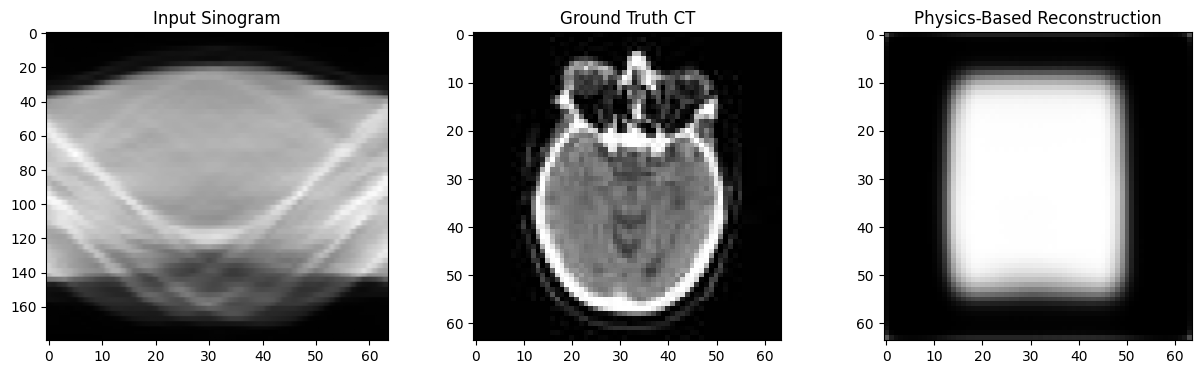

In [ ]:
# Step 5: Evaluation
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Visualization
i = 5
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_test[i].squeeze(), cmap='gray', aspect='auto')
plt.title("Input Sinogram")

plt.subplot(1, 3, 2)
plt.imshow(y_test[i].squeeze(), cmap='gray')
plt.title("Ground Truth CT")

plt.subplot(1, 3, 3)
plt.imshow(pred.squeeze(), cmap='gray')
plt.title("Physics-Based Reconstruction")
plt.show()


In [ ]:
# Quantitative Metrics
psnr_list = []
ssim_list = []

for i in range(len(x_test)):
    pred = model.predict(x_test[i:i+1])[0].squeeze()
    gt = y_test[i].squeeze()

    psnr_val = psnr(gt, pred, data_range=1.0)
    ssim_val = ssim(gt, pred, data_range=1.0)

    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)

print(f"🚀 Physics Model PSNR: {np.mean(psnr_list):.2f} dB")
print(f"🚀 Physics Model SSIM: {np.mean(ssim_list):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
🚀 Physics Model PSNR: 13.43 dB
🚀 Physics Model SSI